In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
#load data

In [4]:
daily_df = pd.read_csv("dataset/stations_daily.csv")

In [5]:
# hourly_df = pd.read_csv("dataset/stations_hourly.csv")

In [6]:
rsinaica_df = pd.read_csv("dataset/stations_rsinaica.csv")

# จัดการกับข้อมูลรายงานฝุ่นรายวันก่อน

we will use this dataframe to calculate the yearly statistic of ฝุ่น

In [7]:
daily_df.head()

,datetime,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,...,HCT,HRI,IUV,PB,PP,PST,RS,TMPI,UVA,XIL
0,2015-04-02,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.361000,NaN,NaN
1,2015-05-21,32,0.454967,0.347400,0.059194,0.029176,NaN,44.879091,0.029525,0.053121,...,NaN,NaN,NaN,570.775455,0.296364,NaN,7.871636,16.792818,NaN,NaN
2,2015-05-22,32,0.077821,0.389323,0.019158,0.051903,NaN,42.506000,0.009589,0.014215,...,NaN,NaN,NaN,558.360000,0.002750,NaN,384.788079,17.018949,NaN,NaN
3,2015-05-23,32,0.018036,0.387729,0.019711,0.021092,0.144603,54.734437,0.009863,0.013436,...,NaN,NaN,NaN,573.282187,0.038750,NaN,252.605975,18.575000,NaN,NaN
4,2015-05-24,32,0.024935,0.398042,0.024757,0.009568,0.494143,58.374574,0.012397,0.010337,...,NaN,NaN,NaN,572.169574,0.003404,NaN,259.231664,16.781064,NaN,NaN


Let's add year and month columns to daily_df 

In [8]:
daily_df.insert(1, "year", daily_df["datetime"].apply(lambda x: x.split("-")[0]))
daily_df.insert(1, "month", daily_df["datetime"].apply(lambda x: x.split("-")[1]))

convert month and year to int \
then sort values by month and year

In [55]:
daily_df["month"] = pd.to_numeric(daily_df["month"])
daily_df["year"] = pd.to_numeric(daily_df["year"])

daily_df.sort_values(by=["year", "month"], inplace = True)
daily_df

,datetime,month,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
0,2013-01-01,1,2013,68,37.084448,79.583333,NaN,0.014000,0.418750,NaN,NaN,NaN,NaN
1,2013-01-02,1,2013,68,16.040586,61.333333,NaN,0.011917,0.383750,NaN,NaN,NaN,NaN
2,2013-01-03,1,2013,68,11.880552,57.739130,NaN,0.015958,0.364583,NaN,NaN,NaN,NaN
3,2013-01-04,1,2013,68,13.000137,55.375000,NaN,0.013208,0.420833,NaN,NaN,NaN,NaN
4,2013-01-05,1,2013,68,18.025929,72.625000,NaN,0.012542,0.431667,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
189800,2021-12-27,12,2021,426,28.956522,67.375000,0.036429,0.030750,1.684583,56.541667,0.012439,0.024762,21.660833
189801,2021-12-28,12,2021,426,20.818182,55.833333,0.037508,0.026792,1.700000,44.375000,0.012439,0.023225,23.731250
189802,2021-12-29,12,2021,426,16.857143,51.458333,0.045588,0.017083,1.732917,37.875000,0.012439,0.026500,22.751250
189803,2021-12-30,12,2021,426,21.555556,51.750000,0.037229,0.029833,1.520000,42.916667,0.012439,0.023929,22.988333


count the values exist each year

In [10]:
groupDaily_by_year = daily_df.groupby("year")
groupDaily_by_year.count()

,datetime,month,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,...,HCT,HRI,IUV,PB,PP,PST,RS,TMPI,UVA,XIL
year,,,,,,,,,,,,,,,,,,,,,
2000,1678,1678,1678,0,0,0,0,0,0,1678,...,0,0,0,0,0,0,0,0,0,0
2001,1658,1658,1658,0,0,0,0,0,0,1658,...,0,0,0,0,0,0,0,0,0,0
2002,826,826,826,0,0,0,0,0,0,826,...,0,0,0,0,0,0,0,0,0,0
2006,321,321,321,0,0,0,0,0,0,321,...,0,0,0,0,0,0,0,0,0,0
2007,44,44,44,0,0,0,0,0,0,44,...,0,0,0,0,0,0,0,0,0,0
2008,43,43,43,0,0,0,0,0,0,43,...,0,0,0,0,0,0,0,0,0,0
2009,43,43,43,0,0,0,0,0,0,43,...,0,0,0,0,0,0,0,0,0,0
2010,10417,10417,10417,3814,7612,151,8235,6816,151,1069,...,0,0,0,140,0,0,0,0,0,0
2011,11315,11315,11315,5374,8473,61,10057,6298,65,1836,...,0,29,0,36,27,0,0,25,0,0


In [11]:
# we will keep a year if PM2.5 have data > 50 %
def keep_year(group):
    return ((group.count()["PM2.5"] * 100) / group.count()["datetime"] > 50)
daily_df = groupDaily_by_year.filter(keep_year)

filter data

In [12]:
daily_df = groupDaily_by_year.filter(keep_year)
daily_df["year"].unique()

array([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

next we will drop column which have few data

In [13]:
daily_df.isna().sum()* 100 / len(daily_df)

#show % of Nan values in each column, we will drop at 51 %

datetime        0.000000
month           0.000000
year            0.000000
station_id      0.000000
PM2.5          23.970884
PM10           19.419134
NOx            41.364588
O3             15.611430
CO             20.965542
HR             35.960491
NO             43.242666
NO2            24.668069
TMP            34.016287
BEN            99.596476
CH4            99.859417
CN             99.690198
CO2            99.970842
H2S            99.854211
HCNM           99.854731
HCT           100.000000
HRI            94.701601
IUV            97.430464
PB             52.365431
PP             60.863385
PST           100.000000
RS             60.719678
TMPI           82.110092
UVA            91.752491
XIL            99.596476
dtype: float64

Too many Nan values OMG

In [14]:
for col in daily_df:
    if daily_df[col].isna().sum()* 100 / len(daily_df) > 51:
        daily_df.drop(col, axis=1,inplace=True)

daily_df.reset_index(drop = True)

,datetime,month,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
0,2013-01-01,1,2013,68,37.084448,79.583333,NaN,0.014000,0.418750,NaN,NaN,NaN,NaN
1,2013-01-02,1,2013,68,16.040586,61.333333,NaN,0.011917,0.383750,NaN,NaN,NaN,NaN
2,2013-01-03,1,2013,68,11.880552,57.739130,NaN,0.015958,0.364583,NaN,NaN,NaN,NaN
3,2013-01-04,1,2013,68,13.000137,55.375000,NaN,0.013208,0.420833,NaN,NaN,NaN,NaN
4,2013-01-05,1,2013,68,18.025929,72.625000,NaN,0.012542,0.431667,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
192053,2021-12-27,12,2021,426,28.956522,67.375000,0.036429,0.030750,1.684583,56.541667,NaN,0.024762,21.660833
192054,2021-12-28,12,2021,426,20.818182,55.833333,0.037508,0.026792,1.700000,44.375000,NaN,0.023225,23.731250
192055,2021-12-29,12,2021,426,16.857143,51.458333,0.045588,0.017083,1.732917,37.875000,NaN,0.026500,22.751250
192056,2021-12-30,12,2021,426,21.555556,51.750000,0.037229,0.029833,1.520000,42.916667,NaN,0.023929,22.988333


In [15]:
# Drop form AQI values for PM2.5 as per health standards

daily_df.drop(daily_df[daily_df["PM2.5"] > 500.4].index,inplace=True)
daily_df = daily_df.reset_index(drop=True)
daily_df

,datetime,month,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
0,2013-01-01,1,2013,68,37.084448,79.583333,NaN,0.014000,0.418750,NaN,NaN,NaN,NaN
1,2013-01-02,1,2013,68,16.040586,61.333333,NaN,0.011917,0.383750,NaN,NaN,NaN,NaN
2,2013-01-03,1,2013,68,11.880552,57.739130,NaN,0.015958,0.364583,NaN,NaN,NaN,NaN
3,2013-01-04,1,2013,68,13.000137,55.375000,NaN,0.013208,0.420833,NaN,NaN,NaN,NaN
4,2013-01-05,1,2013,68,18.025929,72.625000,NaN,0.012542,0.431667,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
189800,2021-12-27,12,2021,426,28.956522,67.375000,0.036429,0.030750,1.684583,56.541667,NaN,0.024762,21.660833
189801,2021-12-28,12,2021,426,20.818182,55.833333,0.037508,0.026792,1.700000,44.375000,NaN,0.023225,23.731250
189802,2021-12-29,12,2021,426,16.857143,51.458333,0.045588,0.017083,1.732917,37.875000,NaN,0.026500,22.751250
189803,2021-12-30,12,2021,426,21.555556,51.750000,0.037229,0.029833,1.520000,42.916667,NaN,0.023929,22.988333


fillna

In [16]:
# for y in daily_df["year"].unique():
#     for m in daily_df["month"].unique():
#         daily_df.update(daily_df.loc[(daily_df["year"]==y) & (daily_df["month"]==m),"PM2.5"].fillna(add_PM2_5[y][m]["mean"]))
#         daily_df.update(daily_df.loc[(daily_df["year"]==y) & (daily_df["month"]==m),"PM10"].fillna(add_PM10[y][m]["mean"]))

daily_df=daily_df.fillna(method="ffill")

In [17]:
group_y = daily_df.groupby("year")
group_y["PM2.5"].mean()

year
2013    24.785316
2014    24.361142
2015    26.845259
2016    24.564272
2017    25.062333
2018    22.240094
2019    22.175097
2020    21.813819
2021    22.213570
Name: PM2.5, dtype: float64

# Heatmap correlation

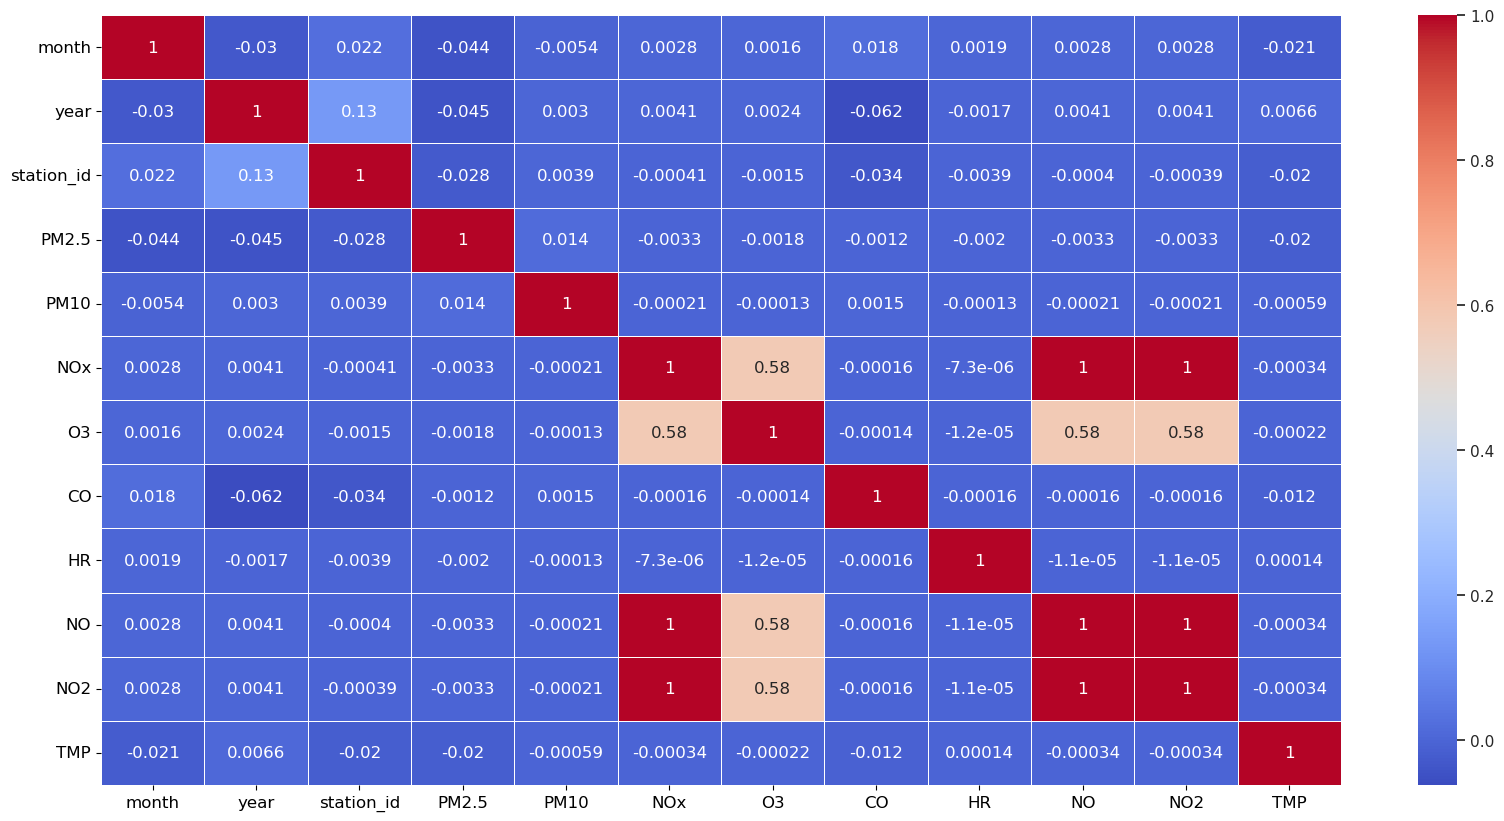

In [18]:
data_to_corr = daily_df.iloc[:,1:]
plt.gcf().set_size_inches(20, 10)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
sns.set(font_scale=1)
dataplot = sns.heatmap(data_to_corr.corr(), cmap="coolwarm", annot = True, linewidths=.5)

# Graph PM2.5 and PM10

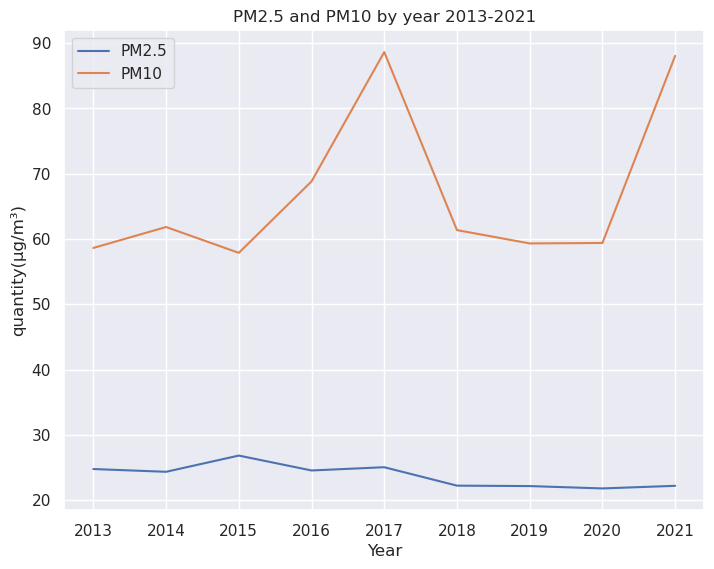

In [19]:
line_Graph = plt.figure()

ax = line_Graph.add_axes([0,0,1,1])
ax.set_title('PM2.5 and PM10 by year 2013-2021')
plt.xlabel('Year')
plt.ylabel('quantity(µg/m³)')
ax.plot(group_y["PM2.5"].mean(), label="PM2.5")
ax.plot(group_y["PM10"].mean(), label="PM10")
ax.legend()

In [20]:
# p1_df = pd.DataFrame({"Average PM2.5": daily_df.groupby("year")["PM2.5"].mean()}).reset_index()
# p1_df
# p1_df.plot("year", "Average PM2.5", kind='bar', color="#337fff", width=0.5);
# plt.xlabel('Year')
# plt.ylabel('PM2.5 quantity(µg/m³)')
# plt.yticks(fontsize=20)
# plt.xticks(fontsize=20)
# plt.legend()
# plt.xticks(rotation = 45)

In [21]:
daily_df

,datetime,month,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
0,2013-01-01,1,2013,68,37.084448,79.583333,NaN,0.014000,0.418750,NaN,NaN,NaN,NaN
1,2013-01-02,1,2013,68,16.040586,61.333333,NaN,0.011917,0.383750,NaN,NaN,NaN,NaN
2,2013-01-03,1,2013,68,11.880552,57.739130,NaN,0.015958,0.364583,NaN,NaN,NaN,NaN
3,2013-01-04,1,2013,68,13.000137,55.375000,NaN,0.013208,0.420833,NaN,NaN,NaN,NaN
4,2013-01-05,1,2013,68,18.025929,72.625000,NaN,0.012542,0.431667,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
189800,2021-12-27,12,2021,426,28.956522,67.375000,0.036429,0.030750,1.684583,56.541667,0.012439,0.024762,21.660833
189801,2021-12-28,12,2021,426,20.818182,55.833333,0.037508,0.026792,1.700000,44.375000,0.012439,0.023225,23.731250
189802,2021-12-29,12,2021,426,16.857143,51.458333,0.045588,0.017083,1.732917,37.875000,0.012439,0.026500,22.751250
189803,2021-12-30,12,2021,426,21.555556,51.750000,0.037229,0.029833,1.520000,42.916667,0.012439,0.023929,22.988333


# statistic by season

In [22]:
# month with avr
daily_df.groupby("month").mean()

,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
month,,,,,,,,,,,
1,2017.545279,168.915690,28.692543,121.842142,0.174634,0.080526,113.872137,74.530111,0.090640,0.085525,24.702816
2,2017.523935,169.824454,25.216477,65.637062,0.149484,0.062389,39.644320,50.176382,0.072178,0.084750,25.023354
3,2017.498957,170.868859,24.243734,67.004413,0.120910,0.079423,1.811197,242.868838,0.045601,0.078883,25.352027
4,2017.502702,169.217893,27.798886,71.833701,0.312861,0.180628,1.732950,48.317296,0.103244,0.223940,27.702978
5,2017.489421,169.978652,26.439428,63.735481,0.230727,0.372705,8.788348,51.189698,0.082165,0.450259,31.532057
6,2017.479243,170.950042,19.906022,52.675868,0.122668,0.281115,1.101862,60.606535,0.043491,0.084893,27.156402
7,2017.449905,171.702858,20.850387,53.811826,0.466618,0.250241,1.130601,64.738553,0.355838,0.131735,28.270226
8,2017.365999,173.584542,18.505698,51.292613,0.400440,0.171856,1.196008,66.287507,0.209079,0.110743,28.577607
9,2017.344869,174.861251,19.195239,54.492711,609.273833,3.490752,1.780556,67.834108,608.952520,608.900681,26.752297


In [23]:
# In Mexico, hot season are 1, 2, 3, 4, 11, 12
hot_s = daily_df.groupby("month").mean().drop([5, 6, 7, 8, 9, 10]).mean().to_frame().T.assign(season=["hot_season"]).set_index("season")
hot_s

,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
season,,,,,,,,,,,
hot_season,2017.458438,171.355456,26.406059,79.61774,0.334699,0.09909,68.02363,88.87229,0.143302,0.1206,23.576384


In [24]:
# In Mexico, wet season are 5, 6, 7, 8, 9, 10
wet_s = daily_df.groupby("month").mean()[4:10].mean().to_frame().T.assign(season=["wet_season"]).set_index("season")
wet_s

,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
season,,,,,,,,,,,
wet_season,2017.412229,172.671753,20.786425,55.897854,101.852011,0.779858,4.815478,236.266455,101.662196,101.636075,27.685443


In [25]:
# merge season
season = hot_s.append(wet_s)
season

,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
season,,,,,,,,,,,
hot_season,2017.458438,171.355456,26.406059,79.617740,0.334699,0.099090,68.023630,88.872290,0.143302,0.120600,23.576384
wet_season,2017.412229,172.671753,20.786425,55.897854,101.852011,0.779858,4.815478,236.266455,101.662196,101.636075,27.685443


### compare wet and hot season

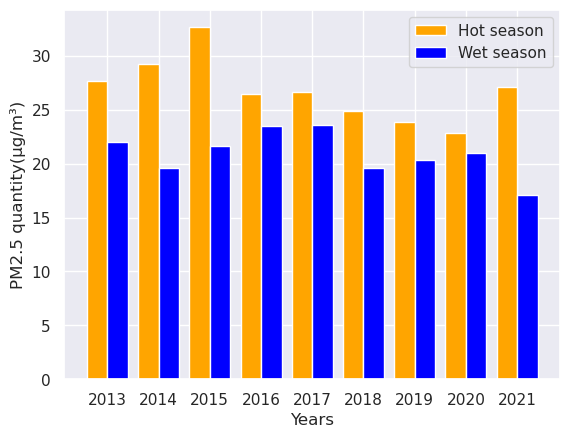

In [26]:
hot_s_list, wet_s_list = [], []
year = list(range(2013, 2022))
x = np.arange(9)
for i in year:
    hot_s_list.append(daily_df[daily_df["year"] == i].groupby("month").mean().drop([5, 6, 7, 8, 9, 10]).mean()["PM2.5"])
    wet_s_list.append(daily_df[daily_df["year"] == i].groupby("month").mean()[4:10].mean()["PM2.5"])

plt.bar(x-0.2, hot_s_list, 0.4, color="orange")
plt.bar(x+0.2, wet_s_list, 0.4, color="blue")
plt.xticks(x, year)
plt.xlabel("Years")
plt.ylabel("PM2.5 quantity(µg/m³)")
plt.legend(["Hot season", "Wet season"])
plt.show()

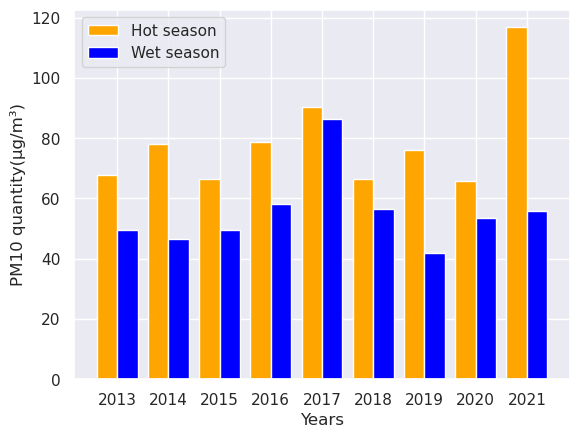

In [27]:
hot_s_list, wet_s_list = [], []
for i in year:
    hot_s_list.append(daily_df[daily_df["year"] == i].groupby("month").mean().drop([5, 6, 7, 8, 9, 10]).mean()["PM10"])
    wet_s_list.append(daily_df[daily_df["year"] == i].groupby("month").mean()[4:10].mean()["PM10"])

plt.bar(x-0.2, hot_s_list, 0.4, color="orange")
plt.bar(x+0.2, wet_s_list, 0.4, color="blue")
plt.xticks(x, year)
plt.xlabel("Years")
plt.ylabel("PM10 quantity(µg/m³)")
plt.legend(["Hot season", "Wet season"])
plt.show()

# hourly_df

In [28]:
# hourly_df.head()

In [29]:
# for y in daily_df["year"].unique()[3:]:
#     value = (mean_y[y])
#     print(y)
#     (daily_df[daily_df["year"]==y]["PM2.5"].fillna(value, inplace = True))


In [30]:
daily_df[daily_df["year"] == 2010]["PM10"]

Series([], Name: PM10, dtype: float64)

In [31]:
# hourly_df.drop_duplicates(["datetime", "station_id"])
# hourly_df.sort_values("datetime")

# rsinaica_df

In [32]:
rsinaica_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station_id         341 non-null    int64  
 1   station_name       341 non-null    object 
 2   station_code       341 non-null    object 
 3   network_id         341 non-null    int64  
 4   network_name       334 non-null    object 
 5   network_code       340 non-null    object 
 6   street             187 non-null    object 
 7   ext                154 non-null    object 
 8   interior           74 non-null     object 
 9   colonia            186 non-null    object 
 10  zip                143 non-null    object 
 11  state_code         299 non-null    float64
 12  municipio_code     299 non-null    float64
 13  year_started       138 non-null    float64
 14  altitude           320 non-null    float64
 15  address            138 non-null    object 
 16  date_validated     20 non-

In [33]:
rsinaica_df

#network_name is city

,station_id,station_name,station_code,network_id,network_name,network_code,street,ext,interior,colonia,...,date_validated2,passed_validation,video,lat,lon,date_started,timezone,street_view,video_interior,color
0,397,"CENICA 1, UAM Iztapalapa",CEN,144,NaN,ESTSP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.489583,-98.801083,2002-01-01,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
1,344,C. Salud Tlaxcoapán,TCP,127,NaN,TCP,NaN,NaN,NaN,NaN,...,NaN,NaN,Array,20.091472,-99.228417,NaN,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
2,365,Costa Baja,UM,140,NaN,LAP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2010-03-14,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
3,393,Unidad Móvil de Hidalgo,UMHI,143,NaN,POP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.489583,-98.801083,2013-05-24,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
4,394,Unidad Móvil Iztapalapa,UMIZ,143,NaN,POP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.489583,-98.801083,2013-05-21,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,239,IMSS Zac,IMSS,118,Zacatecas,ZAC,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,22.775258,-102.566667,NaN,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
337,295,Col. Minera,MIN,118,Zacatecas,ZAC,mina sirena,132,NaN,MINERA,...,NaN,NaN,NaN,22.770455,-102.585126,NaN,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
338,238,ZigZag,ZZZ,118,Zacatecas,ZAC,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,22.762161,-102.578906,NaN,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
339,135,Tecnológico de Zacatepec,TEC,70,Zacatepec,ZAC,Plan de Ayala,27,NaN,Zacatepec de Hidalgo,...,2014-12-31,0.0,https://www.youtube.com/watch?v=J73gPYviTRc,18.654444,-99.183333,2013-12-31,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others


In [34]:
rsinaica_df[rsinaica_df["network_name"].isna()]

,station_id,station_name,station_code,network_id,network_name,network_code,street,ext,interior,colonia,...,date_validated2,passed_validation,video,lat,lon,date_started,timezone,street_view,video_interior,color
0,397,"CENICA 1, UAM Iztapalapa",CEN,144,NaN,ESTSP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.489583,-98.801083,2002-01-01,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
1,344,C. Salud Tlaxcoapán,TCP,127,NaN,TCP,NaN,NaN,NaN,NaN,...,NaN,NaN,Array,20.091472,-99.228417,NaN,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
2,365,Costa Baja,UM,140,NaN,LAP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2010-03-14,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
3,393,Unidad Móvil de Hidalgo,UMHI,143,NaN,POP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.489583,-98.801083,2013-05-24,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
4,394,Unidad Móvil Iztapalapa,UMIZ,143,NaN,POP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.489583,-98.801083,2013-05-21,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
5,395,Unidad Móvil Tecamachalco,UMTE,143,NaN,POP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.489583,-98.801083,2013-05-22,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
6,396,Unidad Móvil Toluca,UMTO,143,NaN,POP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.489583,-98.801083,2013-01-01,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others


In [35]:
# due to only 7 nan value in network_name we will fill it by ourself
# create list of city to fill in nan first
list_miss_city = ["Mexico City", "Tlaxcoapán", "La Paz", "Unknown", "Mexico City", "Tecamachalco", "Toluca"]
for index in np.arange(0,7):
    rsinaica_df.loc[index, "network_name"] = list_miss_city[index]
rsinaica_df.head(7)

,station_id,station_name,station_code,network_id,network_name,network_code,street,ext,interior,colonia,...,date_validated2,passed_validation,video,lat,lon,date_started,timezone,street_view,video_interior,color
0,397,"CENICA 1, UAM Iztapalapa",CEN,144,Mexico City,ESTSP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.489583,-98.801083,2002-01-01,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
1,344,C. Salud Tlaxcoapán,TCP,127,Tlaxcoapán,TCP,NaN,NaN,NaN,NaN,...,NaN,NaN,Array,20.091472,-99.228417,NaN,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
2,365,Costa Baja,UM,140,La Paz,LAP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2010-03-14,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
3,393,Unidad Móvil de Hidalgo,UMHI,143,Unknown,POP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.489583,-98.801083,2013-05-24,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
4,394,Unidad Móvil Iztapalapa,UMIZ,143,Mexico City,POP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.489583,-98.801083,2013-05-21,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
5,395,Unidad Móvil Tecamachalco,UMTE,143,Tecamachalco,POP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.489583,-98.801083,2013-05-22,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
6,396,Unidad Móvil Toluca,UMTO,143,Toluca,POP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.489583,-98.801083,2013-01-01,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others


make new dataframe caontain station_id and network_name(city)

In [43]:
data = {"station_id":rsinaica_df["station_id"],
        "network_name":rsinaica_df["network_name"]}
new_df = pd.DataFrame(data)
new_df

,station_id,network_name
0,397,Mexico City
1,344,Tlaxcoapán
2,365,La Paz
3,393,Unknown
4,394,Mexico City
...,...,...
336,239,Zacatecas
337,295,Zacatecas
338,238,Zacatecas
339,135,Zacatepec


#  prepare data for คำนวณ อับดับเมือง
merge new_df and daily_df

In [37]:
daily_station = pd.merge(daily_df, new_df,on="station_id")

In [51]:
daily_station.sort_values(by=["year", "month"], inplace = True)
daily_station["station_id"].unique()

array([ 68,  70,  72,  73,  74,  75,  77,  78,  82,  92,  93, 102, 103,
       106, 109, 123, 125, 126, 128, 139, 140, 141, 142, 143, 145, 146,
       147, 161, 234, 244, 251, 256, 258, 260, 262, 266, 268, 269, 271,
       388, 160, 129,  53,  56,  59,  60, 134, 163, 148, 162, 245,  85,
        33, 136, 137, 241, 242, 263,  32, 292,  87, 297, 301, 302, 291,
       306,  84, 304, 305, 220, 352, 358, 356, 359, 424, 425, 426, 293])

In [47]:
daily_station

,datetime,month,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP,network_name
0,2013-01-01,1,2013,68,37.084448,79.583333,NaN,0.014000,0.418750,NaN,NaN,NaN,NaN,Celaya
1,2013-01-02,1,2013,68,16.040586,61.333333,NaN,0.011917,0.383750,NaN,NaN,NaN,NaN,Celaya
2,2013-01-03,1,2013,68,11.880552,57.739130,NaN,0.015958,0.364583,NaN,NaN,NaN,NaN,Celaya
3,2013-01-04,1,2013,68,13.000137,55.375000,NaN,0.013208,0.420833,NaN,NaN,NaN,NaN,Celaya
4,2013-01-05,1,2013,68,18.025929,72.625000,NaN,0.012542,0.431667,NaN,NaN,NaN,NaN,Celaya
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189416,2021-12-27,12,2021,426,28.956522,67.375000,0.036429,0.030750,1.684583,56.541667,0.012439,0.024762,21.660833,Monterrey
189417,2021-12-28,12,2021,426,20.818182,55.833333,0.037508,0.026792,1.700000,44.375000,0.012439,0.023225,23.731250,Monterrey
189418,2021-12-29,12,2021,426,16.857143,51.458333,0.045588,0.017083,1.732917,37.875000,0.012439,0.026500,22.751250,Monterrey
189419,2021-12-30,12,2021,426,21.555556,51.750000,0.037229,0.029833,1.520000,42.916667,0.012439,0.023929,22.988333,Monterrey


Ranking of townn

In [40]:
group_town = daily_station.groupby("network_name")
group_town.describe()["PM2.5"]

,count,mean,std,min,25%,50%,75%,max
network_name,,,,,,,,
Abasolo,1531.0,13.650034,8.265728,1.000000,7.998970,12.064819,17.218966,79.609515
Aguascalientes,2978.0,15.970728,40.675263,0.000000,0.031836,4.600000,17.756139,484.081087
Atitalaquia,3177.0,22.656371,19.476695,0.000000,12.144236,20.446535,30.254495,318.314403
Celaya,5234.0,22.599917,25.915695,0.000000,11.813676,17.444823,24.595608,474.648673
Chihuahua,2262.0,21.317955,28.551702,0.013804,11.020833,19.502083,24.669792,463.116667
Cuernavaca,2317.0,29.749614,43.418014,1.178589,12.689677,20.270469,30.000000,475.269902
Durango,4707.0,27.662301,41.519313,0.000000,10.567138,15.930513,25.251473,345.220000
Guadalajara,12716.0,28.450766,33.926641,0.000000,12.066802,20.528354,34.583333,435.456857
Guanajuato,1620.0,11.737366,5.110421,1.500000,8.042398,11.255343,14.583358,45.920819


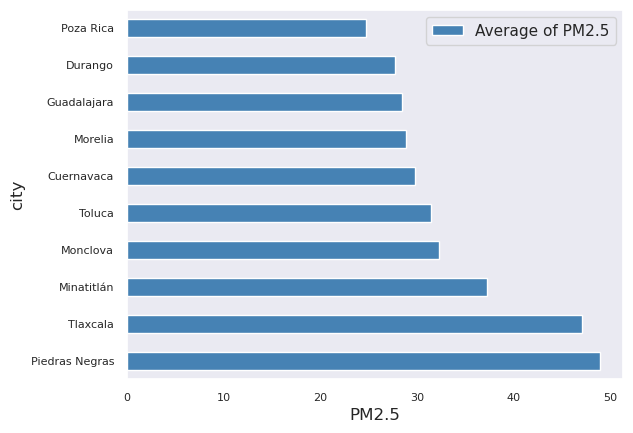

In [41]:
rank_graph = pd.DataFrame({"Average of PM2.5": group_town["PM2.5"].mean().nlargest(10)}).reset_index()
rank_graph.plot("network_name", "Average of PM2.5", kind ='barh', color = '#4682B4', width = 0.5);
plt.xlabel('PM2.5')
plt.ylabel('city')
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.grid(False)
plt.show()